# 1. AlexNet

In [2]:
import tensorflow as tf
import d2l

In [3]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96,kernel_size=11,strides=4,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
        tf.keras.layers.Conv2D(filters=256,kernel_size=5,padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)
    ])

In [5]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


In [6]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.326, train acc 0.880, test acc 0.874
3854.1 examples/sec on /GPU:0


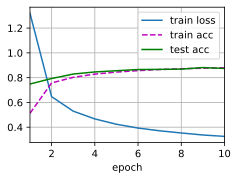

In [9]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.248, train acc 0.908, test acc 0.903
3857.0 examples/sec on /GPU:0


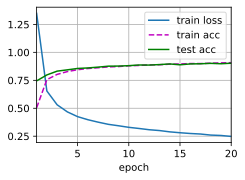

In [8]:
lr, num_epochs = 0.01, 20
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 2. VGG

In [1]:
import tensorflow as tf
import d2l

In [2]:
def vgg_block(num_convs,num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
    return blk

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [5]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # 卷积层部分
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # 全连接层部分
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

In [7]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


In [8]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# 回想一下，这必须是一个将被放入“d2l.train_ch6()”的函数，为了利用我们现有的CPU/GPU设备，这样模型构建/编译需要在strategy.scope()中
net = lambda: vgg(small_conv_arch)

loss 0.170, train acc 0.937, test acc 0.917
2090.9 examples/sec on /GPU:0


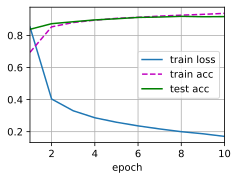

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 3. NiN

In [10]:
import tensorflow as tf
import d2l

In [12]:
def nin_block(num_channels,kernel_size,strides,padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels,kernel_size,strides=strides,padding=padding,activation='relu'),
        tf.keras.layers.Conv2D(num_channels,kernel_size=1,activation='relu'),
        tf.keras.layers.Conv2D(num_channels,kernel_size=1,activation='relu')])

In [13]:
def net():
    return tf.keras.models.Sequential([
        nin_block(96,kernel_size=11,strides=4,padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
        nin_block(256,kernel_size=5,strides=1,padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1, 1, 10)),
        tf.keras.layers.Flatten(),
    ])

In [14]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


loss 0.568, train acc 0.825, test acc 0.818
2635.6 examples/sec on /GPU:0


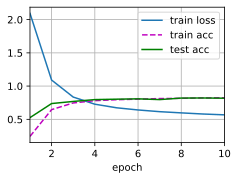

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [16]:
#取消了一层1*1的卷积层
def nin_block2(num_channels,kernel_size,strides,padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels,kernel_size,strides=strides,padding=padding,activation='relu'),
        tf.keras.layers.Conv2D(num_channels,kernel_size=1,activation='relu'),])

In [18]:
def net2():
    return tf.keras.models.Sequential([
        nin_block(96,kernel_size=11,strides=4,padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
        nin_block(256,kernel_size=5,strides=1,padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1, 1, 10)),
        tf.keras.layers.Flatten(),
    ])

In [19]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


loss 0.352, train acc 0.869, test acc 0.879
2658.0 examples/sec on /GPU:0


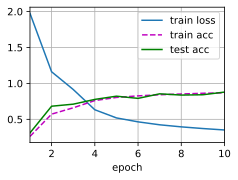

In [20]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 4. GoogLeNet

In [ ]:
import tensorflow as tf
import d2l

In [22]:
class Inception(tf.keras.Model):
    def __init__(self,c1,c2,c3,c4):
        super().__init__()
        self.p1_1 = tf.keras.layers.Conv2D(c1,1,activation='relu')
        
        self.p2_1 = tf.keras.layers.Conv2D(c2[0],1,activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1],3,padding='same',activation='relu')
        
        self.p3_1 = tf.keras.layers.Conv2D(c3[0],1,activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1],5,padding='same',activation='relu')
        
        self.p4_1 = tf.keras.layers.MaxPool2D(3,1,padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4,1,activation='relu')
        
    def call(self,x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

In [24]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,7,strides=2,padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [25]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [26]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [27]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [28]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])

# “net”必须是一个将被传递给“d2l.train_ch6（）”的函数。
# 为了利用我们现有的CPU/GPU设备，这样模型构建/编译需要在“strategy.scope()”
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [29]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


loss 0.227, train acc 0.914, test acc 0.893
3088.4 examples/sec on /GPU:0


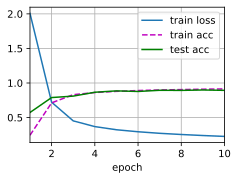

In [31]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 5. Batch Normalization

只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 批量规范化最适应 50∼100 范围中的中等小批量尺寸。

$$
\mathrm{BN}(X) = \gamma \odot \frac{x-\hat{\mu}_B}{\hat{\sigma}_B}+\beta
$$

$$
h = \phi(\mathrm{BN}(Wx+b)
$$

## 5.1 手动实现

In [2]:
import tensorflow as tf
import d2l

In [3]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps):
    inv = tf.cast(tf.math.rsqrt(moving_var+eps),X.dtype)
    inv *= gamma
    Y = X*inv+(beta-moving_mean*inv)
    return Y

In [ ]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6,

# 6. ResNet

In [1]:
import tensorflow as tf
import d2l

In [2]:
class Resdual(tf.keras.Model):
    def __init__(self,num_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels,padding='same',kernel_size=3,strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels,kernel_size=1,strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        
    def call(self,X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)